# CS4320 - Introduction to Machine Learning

## Homework 4: Logistic regression, hyperparameter optimization 

Please type your name and A number here:

In [1]:
Name = "Rylei Mindrum"
assert Name != "", 'Please enter your name in the above quotation marks, thanks!'

A_number = "A02352006"
assert A_number != "", 'Please enter your A-number in the above quotation marks, thanks!'

## Imports 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier

## Exercise 1: implementing `DummyClassifier`
<hr>
rubric={points:25}

You will implement the simplest possible classifier, `DummyClassifier`.

As a reminder, `DummyClassifier` is meant as a baseline and is generally the worst possible "model" you could "fit" to a dataset. All it does is predict the most popular class in the training set. So if there are more label(0) than label(1) it predicts label(0) every time, and if there are more label(1) than label(0) it predicts label(1) every time. For `predict_proba` it looks at the frequencies in the training set, so if you have 30% label(0) 70% label(1) it predicts `[0.3 0.7]` every time. Thus, `fit` only looks at `y` (not `X`).

Below you will find starter code for a class called `MyDummyClassifier`, which has methods `fit()`, `predict()`, `predict_proba()` and `score()`. Your task is to fill in those four functions. To get you started, I have given you a `return` statement in each case that returns the correct data type: `fit` can return nothing, `predict` returns an array whose size is the number of examples, `predict_proba` returns an array whose size is the number of examples x 2, and `score` returns a number.

The next code block has some tests you can use to assess whether your code is working. 

I suggest starting with `fit` and `predict`, and making sure those are working before moving on to `predict_proba`. For `predict_proba`, you should return the frequency of each class in the training data, which is the behaviour of [`DummyClassifier(strategy='prior')`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html?highlight=dummyclassifier+strategy+prior). Your `score` function should call your `predict` function. Again, you can compare with `DummyClassifier` using the code below.

To simplify this question, you can assume **binary classification**, and furthermore that these classes are **encoded as 0 and 1**. In other words, you can assume that `y` contains only 0s and 1s. The real `DummyClassifier` works when you have more than two classes, and also works if the target values are encoded differently, for example as "cat", "dog", "mouse", etc.

In [3]:
class MyDummyClassifier:
    def __init__(self):
        self.most_frequent_class = None
        self.class_probabilities = None

    def fit(self, X, y):
        unique, counts = np.unique(y, return_counts=True)
        self.class_probabilities = counts / len(y)
        self.most_frequent_class = unique[np.argmax(counts)]
        return None 

    def predict(self, X):
        return np.full(X.shape[0], self.most_frequent_class)

    def predict_proba(self, X):
        return np.array([self.class_probabilities] * X.shape[0])

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

Below are some tests for `predict` using randomly generated data. You may want to run the cell a few times to make sure you explore the different cases (or automate this with a loop or random seeds).

In [4]:
n_train = 101
n_valid = 21
d = 5
X_train_dummy = np.random.randn(n_train, d)
X_valid_dummy = np.random.randn(n_valid, d)
y_train_dummy = np.random.randint(2, size=n_train)
y_valid_dummy = np.random.randint(2, size=n_valid)

my_dc = MyDummyClassifier()
sk_dc = DummyClassifier(strategy="prior")

my_dc.fit(X_train_dummy, y_train_dummy)
sk_dc.fit(X_train_dummy, y_train_dummy)

assert np.array_equal(my_dc.predict(X_train_dummy), sk_dc.predict(X_train_dummy))
assert np.array_equal(my_dc.predict(X_valid_dummy), sk_dc.predict(X_valid_dummy))

Below are some tests for `predict_proba`.

In [5]:
assert np.allclose(
    my_dc.predict_proba(X_train_dummy), sk_dc.predict_proba(X_train_dummy)
)
assert np.allclose(
    my_dc.predict_proba(X_valid_dummy), sk_dc.predict_proba(X_valid_dummy)
)

Below are some tests for `score`.

In [6]:
assert np.isclose(
    my_dc.score(X_train_dummy, y_train_dummy), sk_dc.score(X_train_dummy, y_train_dummy)
)
assert np.isclose(
    my_dc.score(X_valid_dummy, y_valid_dummy), sk_dc.score(X_valid_dummy, y_valid_dummy)
)

## Exercise 2: Trump Tweets
<hr>
rubric={points:35}

For the rest of this assignment we'll be looking at a [dataset of Donald Trump's tweets](https://www.kaggle.com/austinreese/trump-tweets) as of June 2020. You should start by downloading the dataset. Unzip it and move the file `realdonaldtrump.csv` into this directory. As usual, please do not submit the dataset when you submit the assignment. 

In [7]:
tweets_df = pd.read_csv("realdonaldtrump.csv", index_col=0)
tweets_df.head()

,link,content,date,retweets,favorites,mentions,hashtags
id,,,,,,,
1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN
1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN
1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,NaN,NaN
1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,NaN,NaN


In [8]:
tweets_df.shape

(43352, 7)

We will be trying to predict whether a tweet will go "viral", defined as having more than 10,000 retweets:

In [9]:
y = tweets_df["retweets"] > 10_000 

To make predictions, we'll be using only the content (text) of the tweet. 

In [10]:
X = tweets_df["content"]

For the purpose of this assignment, you can ignore all the other columns in the original dataset.

#### 2(a) ordering the steps
rubric={points:8}

Let's start by building a model using `CountVectorizer` and `LogisticRegression`. The code required to do this has been provided below, but in the wrong order. 

- Rearrange the lines of code to correctly fit the model and compute the cross-validation score. {points: 4} 
- Add a short comment to each block to describe what the code is doing. {points: 4}

In [11]:
countvec = CountVectorizer(stop_words="english")

lr = LogisticRegression(max_iter=1000)

pipe = make_pipeline(countvec, lr)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=321)

cross_val_results = pd.DataFrame(
    cross_validate(pipe, X_train, y_train, return_train_score=True)
)

cross_val_results.mean()

fit_time       2.330848
score_time     0.162020
test_score     0.897890
train_score    0.967045
dtype: float64

Expected Output. (Note that we round to three decimal places. Your output could have more decimal places. )
- test_score     0.897
- train_score    0.967

#### 2(b) Cross-validation fold sub-scores
rubric={points:3}

Above we averaged the scores from the 5 folds of cross-validation. 

- Print out the 5 individual scores. Reminder: `sklearn` calls them `"test_score"` but they are really (cross-)validation scores. {points:1} 
- Are the 5 scores close to each other or spread far apart? (This is a bit subjective, answer to the best of your ability.) {points:1}
- How does the size of this dataset (number of rows) compare to the cities dataset we have been using in class? How does this relate to the different sub-scores from the 5 folds? {points:1}

In [12]:
print(cross_val_results["test_score"])

0    0.899123
1    0.899739
2    0.896356
3    0.898201
4    0.896032
Name: test_score, dtype: float64


Type your answer:
The 5 scores are relatively close to each other, this indicates that the model is presenting a consistent performance across different validation folds.
This dataset has 43,352 rows, which is quite large in comparison. This relates to the different sub-scores because with larger datasets, each fold has more data, and therefore, we might expect the scores to be more consistent.

#### 2(c) baseline
rubric={points:5}

By the way, are these scores any good? 

- Run `DummyClassifier` (or `MyDummyClassifier`!) on this dataset (You only do cross validation on the training data like (a)). {points:2}
    - Expected Output. Mean cross_val_results is
        - test_score     0.738
        - train_score    0.738
- Compare the `DummyClassifier` score to what you got from logistic regression above. Does logistic regression seem to be doing anything useful? {points:1}
- Is it necessary to use `CountVectorizer` here? Briefly explain. {points:2}

In [13]:
dummy = DummyClassifier(strategy="prior")
dummy_scores = cross_validate(dummy, X_train, y_train, return_train_score=True)
print(pd.DataFrame(dummy_scores).mean())

fit_time       0.004814
score_time     0.001803
test_score     0.738543
train_score    0.738543
dtype: float64


Type your answer:
The logistic regression model's score is better than the DummyClassifier's score, suggesting the logistic regression is learning some patterns from the data which would be considered "useful."
Yes it is necessary to use CountVectorizer. This is because our features are text, and we need to convert them to a numerical format for the model to process.

#### 2(d) probability scores
rubric={points:5}

Here we train a logistic regression classifier on the entire training set: 

(Note: this is relying on the `pipe` variable from 2(a) - you'll need to redefine it if you overwrote that variable in between.)

In [14]:
pipe.fit(X_train, y_train) # train a logistic regression classifier on the entire training set

Pipeline(steps=[('countvectorizer', CountVectorizer(stop_words='english')),
                ('logisticregression', LogisticRegression(max_iter=1000))])

Using this model, find the tweet in the **test set** with the highest predicted probability of being viral. Print out the tweet and the associated probability score.

In [15]:
probs = pipe.predict_proba(X_test)[:, 1]

max_index = np.argmax(probs)

print(X_test.iloc[max_index])
print(probs[max_index])

Corrupt politician Adam Schiff wants people from the White House to testify in his and Pelosi’s disgraceful Witch Hunt, yet he will not allow a White House lawyer, nor will he allow ANY of our requested witnesses. This is a first in due process and Congressional history!
0.9999999325255905


#### 2(e) coefficients
rubric={points:4}

We can extract the `CountVectorizer` and `LogisticRegression` objects from the `make_pipeline` object as follows:

In [16]:
vec_from_pipe = pipe.named_steps["countvectorizer"]
lr_from_pipe = pipe.named_steps["logisticregression"]

Using these extracted components above, display the 5 words with the highest coefficients and the 5 words with the smallest coefficients.

In [17]:
vocab = vec_from_pipe.get_feature_names_out()
coefficients = lr_from_pipe.coef_[0]

df_coeffs = pd.DataFrame({'word': vocab, 'coefficient': coefficients})

print(df_coeffs.nlargest(5, 'coefficient'))

print(df_coeffs.nsmallest(5, 'coefficient'))

              word  coefficient
17729   harassment     2.731874
24999         mini     2.712478
14919         fake     2.692740
10915  coronavirus     2.434353
36825  transcripts     2.380505
                  word  coefficient
30315  realdonaldtrump    -3.116933
37055     trump2016pic    -2.637179
6928       barackobama    -2.565276
37051        trump2016    -2.316005
2219              1pic    -2.294966


- The highest 5 words should be: harassment, mini, fake, coronavirus, transcripts.
- The lowest 5 words should be: 1pic, trump2016, barackobama, trump2016pic, realdonaldtrump

#### 2(f)
rubric={points:10}

scikit-learn provides a lot of useful tools like `make_pipeline` and `cross_validate`, which are awesome. But with these fancy tools it's also easy to lose track of what is actually happening under the hood. Here, your task is to "manually" (without `Pipeline`) compute logistic regression's validation score(that is, train on 80% and validate on 20%) of the training data.

You should start with the following `CountVectorizer` and `LogisticRegression` objects. You only need to furtherly split `X_train` and `y_train` into 80% training set and 20% validation set. Use lr.score() to show your validation score of your model performing on validation set.(In order to grade, we set random_state=123)

In [18]:
countvec = CountVectorizer(stop_words="english")
lr = LogisticRegression(max_iter=1000)  

In [19]:
X_train_small, X_valid, y_train_small, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

X_train_small_transformed = countvec.fit_transform(X_train_small)

X_valid_transformed = countvec.transform(X_valid)

lr.fit(X_train_small_transformed, y_train_small)

score = lr.score(X_valid_transformed, y_valid)
print(score)

0.8929724742426572


Expected output value: 0.893

Meta-comment:I think this type of question (and Exercise 1) is a useful middle ground. I do want you to know what is going on in `Pipeline` and in `cross_validate` even if we don't cover the details of `fit`. To get into logistic regression's `fit` requires a bunch of math; here, we're keeping it more conceptual and avoiding all those prerequisites.

## Exercise 3: hyperparameter optimization
<hr>
rubric={points:25}

#### 3(a)
rubric={points:4}

The following code varies the `max_features` hyperparameter of `CountVectorizer` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `max_features`. It also prints the results. Based on the plot/output, what value of `max_features` seems best? Briefly explain.

Note: the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

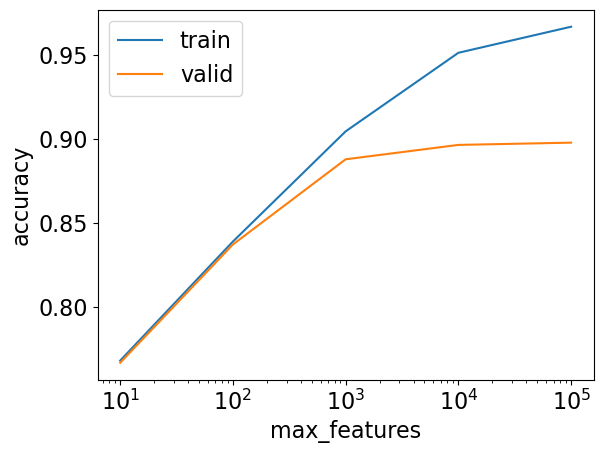

In [20]:
train_scores = []
cv_scores = []

max_features = [10, 100, 1000, 10_000, 100_000]

for mf in max_features:
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=mf),
        LogisticRegression(max_iter=1000),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)
    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(max_features, train_scores, label="train")
plt.semilogx(max_features, cv_scores, label="valid")
plt.legend()
plt.xlabel("max_features")
plt.ylabel("accuracy");
plt.show()

In [21]:
pd.DataFrame({"max_features": max_features, "train": train_scores, "cv": cv_scores})

,max_features,train,cv
0,10,0.767854,0.766593
1,100,0.838900,0.837147
2,1000,0.904626,0.887956
3,10000,0.951498,0.896537
4,100000,0.967045,0.897890


Type your answer here: the 100000 max_features has the highest train and cv scores. 

#### 3(b)
rubric={points:4}

The following code varies the `C` hyperparameter of `LogisticRegression` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `C`. Based on the plot, what value of `C` seems best?

Note: the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

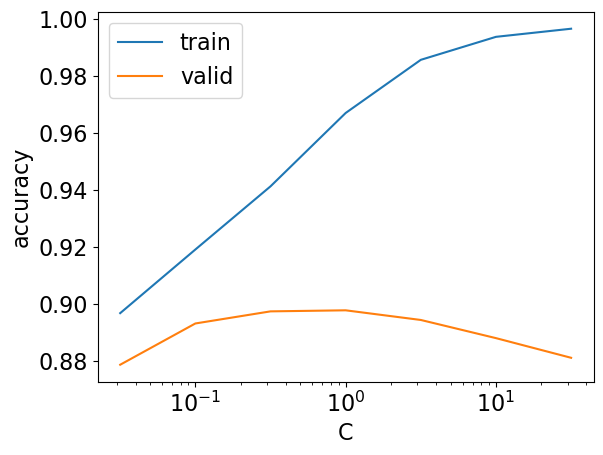

In [22]:
train_scores = []
cv_scores = []

C_vals = 10.0 ** np.arange(-1.5, 2, 0.5)

for C in C_vals:
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=None),
        LogisticRegression(max_iter=1000, C=C),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)

    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(C_vals, train_scores, label="train")
plt.semilogx(C_vals, cv_scores, label="valid")
plt.legend()
plt.xlabel("C")
plt.ylabel("accuracy");
plt.show()

In [23]:
pd.DataFrame({"C": C_vals, "train": train_scores, "cv": cv_scores})

,C,train,cv
0,0.031623,0.896898,0.878821
1,0.100000,0.919196,0.893277
2,0.316228,0.941333,0.897521
3,1.000000,0.967045,0.897890
4,3.162278,0.985675,0.894507
5,10.000000,0.993733,0.888140
6,31.622777,0.996578,0.881251


Type your answer here: 3 has the highest scores acorss the board this suggests that as the process continued past this it became overfit. 3 had a perfect C score, the highest train score at .967 and the highest cv at .898.

#### 3(c)
rubric={points:12}

- Using `GridSearchCV`, jointly optimize `max_features` and `C` across all the combinations of values we tried above.{points:8} 
  - Note: the code might be a bit slow here. 
  - Setting `n_jobs=-1` should speed it up if you have a multi-core processor.
  - You can reduce the number of folds (e.g. `cv=2`) to speed it up if necessary.
- What are the best values of `max_features` and `C` according to your grid search?(You can just print your best values){points:4}

In [24]:
pipe = make_pipeline(
    CountVectorizer(stop_words="english"),
    LogisticRegression(max_iter=1000),
)

param_grid = {
    'countvectorizer__max_features': [10, 100, 1000, 10_000, 100_000],
    'logisticregression__C': 10.0 ** np.arange(-1.5, 2, 0.5)
}

grid_search = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1, return_train_score=True)
grid_search.fit(X_train, y_train)

print("Best max_features:", grid_search.best_params_['countvectorizer__max_features'])
print("Best C:", grid_search.best_params_['logisticregression__C'])

Best max_features: 10000
Best C: 0.31622776601683794


Please print out your best values of max_feature and C. They should be 100000 and 0.316 respectively.

#### 3(d)
rubric={points:5}

- Evaluate your final model on the test set.{points:3} 
    - Expected test accuracy is 0.899
- How does your test accuracy compare to your validation accuracy?{points:2} 

In [25]:
best_pipe = grid_search.best_estimator_
test_score = best_pipe.score(X_test, y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.8964753644583872


Type your answer here: my test accuracy landed at .8964 which is relatively close to the expected 8.99 as it is less than a .003 difference. 

## Exercise 4: Very short answer questions
rubric={points:15}

Each question is worth 3 points.

1. What is the problem with calling `fit_transform` on your test data with `CountVectorizer`? 
2. Why is it important to follow the Golden Rule? If you violate it, will that give you a worse classifier?
3. If you could only access one of `predict` or `predict_proba`, which one would you choose? Briefly explain.
4. What are two advantages of using sklearn `Pipeline`s? 
5. What are two advantages of `RandomizedSearchCV` over `GridSearchCV`?

Type your answer here:

1. Calling fit_transform on test data with CountVectorizer, essentially fits the vectorizer to the test data. This means that the vocabulary and any internal parameters are set based on the test data. This violates the principle of keeping your training and testing processes separate. If new words appear in the test data that weren't in the training data, they would be incorporated, potentially changing the structure of your feature space and introducing data leakage.

2. It's important to follow it to ensure that the evaluation of your model is unbiased and genuinely represents its performance on unseen data. Violating the Golden Rule might not necessarily give you a worse classifier, but it will give you a misleadingly optimistic estimate of how well your classifier will perform in real-world scenarios because you've basically "cheated" by giving your model a peek at the answers.

3. If I could only access one of predict or predict_proba, I would choose predict_proba. I would choose predict_proba because it provides the raw probability scores which can be thresholded for the class predictions, allowing one to adjust the decision threshold. 

4. a) Consistency and Simplicity - ensures that the same preprocessing steps are applied to both training and test datasets, reducing the chances of potential mistakes or inconsistencies.
   b) Convenience -useful for cross-validation and hyperparameter tuning, where the same sequence of processing steps can be reused multiple times.

5. a) Computational Efficiency - RandomizedSearchCV is often much faster and can lead to similarly effective results as GridSearchCV.
    b) Ability to Sample from Distributions - w/ RandomizedSearchCV you can specify a continuous distribution for a hyperparameter (GridSearchCV is a list of values), beneficial if you have no idea what the ideal value might be and want to sample broadly.

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`.
2. Notebooks with cell execution numbers out of order will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Please keep your notebook clean and delete any throwaway code.